In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
from dt import *
from rfc import *
from svm import *
from lr import *

In [2]:
import pandas as pd 
import csv
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter, defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer

# col_list=['screen_name','tweet','hashtag','url','#retweets','#favorites','label']
col_list=['screen_name','tweet','label']
df=pd.read_csv('C:/ds4cg2020/data/labeledtweets-flu.csv', usecols =col_list) 
df2=pd.read_csv('C:/ds4cg2020/data/january_flu_tweets.csv', usecols =col_list)
# df['burl'] = df['url'].apply(lambda x: 1 if not pd.isnull(x) else 0)
# df['bhashtag'] = df['hashtag'].apply(lambda x: 1 if len(x) > 4 else 0)
forbidden_keys="kung flu"
for i,v in enumerate(df['tweet']):
    if forbidden_keys in df.at[i,'tweet'].lower():
        df.at[i,'label']=np.nan

In [3]:
def clean_df(df):
    df=df.dropna(subset=['label'])
    df=df[df.label != '?']
    df=df[df.label != 'no content']
    df=df.sort_values(by=['label'])
    df=df.dropna(subset=['tweet'])
    return df

In [4]:
df=clean_df(df)
df2=clean_df(df2)
df=df.append(df2)

In [5]:
df.label.value_counts()

TRUE    226
Fake    192
Name: label, dtype: int64

In [6]:
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    tweet = re.sub(r"http\S+", "", tweet)
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [7]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
df['normalized_tweet'] = df.tweet.apply(normalizer)
df[['tweet','normalized_tweet']].head()

C:\Users\nazan\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,tweet,normalized_tweet
633,"0.01% death rate, lower than the seasonal flu! #CoronaVirusHOAX #OPENAMERICANOW https://t.co/nDNgTy6HY7","[lower, seasonal, flu, coronavirushoax, openamericanow]"
198,"@JuliansRum 100,000 coronavirus cases or 100,000 influenza cases? \nSymptoms used to diagnose coronavirus same as the flu.\n\nInfluenza positive cases in week 10, 12 and 14 same time as COVID19 cases rise. https://t.co/eNVg5SrehN","[case, influenza, case, symptom, used, diagnose, coronavirus, flu, influenza, positive, case, week, time, covid, case, rise]"
467,@KLFY It’s all a Hoax and a farce. Not any worse than the seasonal flu. All the hype is politically motivated. Almost all of Flu cases have been claimed as Covid19. All China based Virus is a Coronavirus. Covid19 is a different strain of the Seasonal Flu. KLFY research that..,"[hoax, farce, worse, seasonal, flu, hype, politically, motivated, almost, flu, case, claimed, covid, china, based, virus, coronavirus, covid, different, strain, seasonal, flu, klfy, research]"
205,"OUTRAGE as NEW YORK medical community moved 8,000 deaths in 1 Month from #HeartDisease, #Cancer, #Accidents, #Stroke, #Alzheimer's, #Homicide, etc. into #Covid19 Column #CoronaVirus #ChinaVirus #FauciFraud #FireFauci #FireBirx #DefundCDC #NYC #GovCoumo #NewYorkFraud #Flu #Fraud https://t.co/HwFFT2fEQV","[new, york, medical, community, moved, death, month, heartdisease, cancer, accident, stroke, alzheimer, homicide, etc, covid, column, coronavirus, chinavirus, faucifraud, firefauci, firebirx, defundcdc, nyc, govcoumo, newyorkfraud, flu, fraud]"
209,"@dikell3 @GovMikeDeWine Dianne, 2016/2017 flu season had 29,000,000 infections. Covid19 is world's 7th coronavirus. Did you wear 😷 past seasons? Why now?","[dianne, flu, season, infection, covid, world, th, coronavirus, wear, past, season]"


In [8]:
df2=df[df.astype(str)['normalized_tweet'] != '[]']

In [9]:
df2

,screen_name,tweet,label,normalized_tweet
633,MAGAGramie,"0.01% death rate, lower than the seasonal flu! #CoronaVirusHOAX #OPENAMERICANOW https://t.co/nDNgTy6HY7",Fake,"[lower, seasonal, flu, coronavirushoax, openamericanow]"
198,PatriotAust,"@JuliansRum 100,000 coronavirus cases or 100,000 influenza cases? \nSymptoms used to diagnose coronavirus same as the flu.\n\nInfluenza positive cases in week 10, 12 and 14 same time as COVID19 cases rise. https://t.co/eNVg5SrehN",Fake,"[case, influenza, case, symptom, used, diagnose, coronavirus, flu, influenza, positive, case, week, time, covid, case, rise]"
467,LegerDouglas,@KLFY It’s all a Hoax and a farce. Not any worse than the seasonal flu. All the hype is politically motivated. Almost all of Flu cases have been claimed as Covid19. All China based Virus is a Coronavirus. Covid19 is a different strain of the Seasonal Flu. KLFY research that..,Fake,"[hoax, farce, worse, seasonal, flu, hype, politically, motivated, almost, flu, case, claimed, covid, china, based, virus, coronavirus, covid, different, strain, seasonal, flu, klfy, research]"
205,PRNPool,"OUTRAGE as NEW YORK medical community moved 8,000 deaths in 1 Month from #HeartDisease, #Cancer, #Accidents, #Stroke, #Alzheimer's, #Homicide, etc. into #Covid19 Column #CoronaVirus #ChinaVirus #FauciFraud #FireFauci #FireBirx #DefundCDC #NYC #GovCoumo #NewYorkFraud #Flu #Fraud https://t.co/HwFFT2fEQV",Fake,"[new, york, medical, community, moved, death, month, heartdisease, cancer, accident, stroke, alzheimer, homicide, etc, covid, column, coronavirus, chinavirus, faucifraud, firefauci, firebirx, defundcdc, nyc, govcoumo, newyorkfraud, flu, fraud]"
209,jmr568ccc,"@dikell3 @GovMikeDeWine Dianne, 2016/2017 flu season had 29,000,000 infections. Covid19 is world's 7th coronavirus. Did you wear 😷 past seasons? Why now?",Fake,"[dianne, flu, season, infection, covid, world, th, coronavirus, wear, past, season]"
...,...,...,...,...
48,Nanyingih,"FLU VIRUSES JUMPING INTO PANDEMICS\n\nEpidemiologic shifts, virus mutations and vaccinology showcased as the world is wakes up to 2019 2019-nCoV a relative of SARS or MERSCOV, the number of nCoV cases &gt;300, 9 deaths in 🇨🇳 1 case confirmed in 🇺🇸 \n\nhttps://t.co/4J3li4tPSB",TRUE,"[jumping, pandemic, epidemiologic, shift, virus, mutation, vaccinology, showcased, world, wake, ncov, relative, sars, merscov, number, ncov, case, gt, death, case, confirmed]"
3,Wolf_InTheWilds,@rebelfd @MackayIM The ones who died already had serious illness. And the estimated amount last week was over 2000. The mortality rate is below 0.5pct. Understand the statistics of infection. Many mild cases do not get reported. CDC estimates of flu deaths are also based on statistical sampling,TRUE,"[one, died, already, serious, illness, estimated, amount, last, week, mortality, rate, pct, understand, statistic, infection, many, mild, case, get, reported, cdc, estimate, flu, death, also, based, statistical, sampling]"
438,semfyc_int,"""It is not easy to detect and count cases, since we are in the annual flu epidemic and that symptoms are very similar. On the other hand, the Wuhan council health website has been publishing live the numbers of affected people. This seems unthinkable in Europe""\n\n⛑️ \n(4a/8)\n👇 https://t.co/HVsT1gNfcX",TRUE,"[easy, detect, count, case, since, annual, flu, epidemic, symptom, similar, hand, wuhan, council, health, website, publishing, live, number, affected, people, seems, unthinkable, europe]"
26,umkcIM,"Subjective flu like symptoms is common presentation\nWhen should you suspect #2019-nCoV? If in the 14 days before symptom onset, patient had a history of travel from Wuhan City, China or close contact with a person who is under investigation for 2019-nCoV while that person was ill https://t.co/yXSSwxuZBU",TRUE,"[like, symptom, common, presentation, suspect, ncov, day, symptom, onset, patient, history, travel, wuhan, city, china, close, contact, person, investigation, ncov, person, ill]"


In [10]:
X=df2.normalized_tweet.values


In [11]:
X.shape

(417,)

In [12]:
from gensim.models.word2vec import Word2Vec

In [30]:
model = Word2Vec(X, size=100, window=5, min_count=5, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

C:\Users\nazan\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [31]:
len(w2v.values())

310

In [32]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

    
# and a tf-idf version of the same
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        print(len(word2vec.values()))
        if len(word2vec)>0:
            self.dim= len(word2vec.values())
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(100)], axis=0)
                for words in X
            ])

In [33]:
y = df2['label'].values

In [ ]:
etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

In [34]:
tfif= TfidfEmbeddingVectorizer(w2v)


310


In [35]:
tfif.fit(X,y)

In [36]:
tf_vector=tfif.transform(X)

In [37]:
tf_vector.shape

(417, 100)

In [22]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score

In [23]:
class RandomForest:
    def __init__(self,RSEED=50,MAX_DEPTH=20,n_estimators=100):
        self.rseed=RSEED 
        self.max_depth=MAX_DEPTH
        self.n_estimators=n_estimators
    def train(self,X,y):
        model = RandomForestClassifier(n_estimators=self.n_estimators, 
                               bootstrap = True,
                               max_features = 'sqrt')
        # Fit on training data
        indices = np.arange(len(X))
        train_idx, test_idx, y_train, y_test= train_test_split(indices, y,stratify = y, test_size=0.25, random_state=42)
        train_X = X[train_idx]
        test_X = X[test_idx]
        model=model.fit(train_X,y_train)

        return model,test_X, y_test,y_train,train_X,train_idx, test_idx

    def evaluate(self,model,test_X, y_test,y_train,train_X):
        """Compare machine learning model to baseline performance.
        Computes statistics and shows ROC curve."""
        results = {}
        
        print(f'Model Accuracy: {model.score(test_X, y_test)}')
        train_probs = model.predict_proba(train_X)[:, 1]
        probs = model.predict_proba(test_X)[:, 1]

        train_predictions = model.predict(train_X)
        predictions = model.predict(test_X)


        print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
        print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')
        


        results['recall'] = recall_score(y_test, predictions, average="binary", pos_label='Fake')
        results['precision'] = precision_score(y_test, predictions, average="binary", pos_label='Fake')
        results['roc'] = roc_auc_score(y_test, probs)
        print(results)
        return y_test,predictions

In [ ]:
rf=RandomForest(RSEED=50,MAX_DEPTH=20,n_estimators=100)

In [ ]:
clf,test_X, y_test,y_train,train_X,train_idx, test_idx=rf.train(tf_vector,y)
y_test,predictions=rf.evaluate(clf,test_X, y_test,y_train,train_X)
cm = confusion_matrix(y_test, predictions)

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Oranges):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.figure(figsize = (10, 10))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title, size = 24)
        plt.colorbar(aspect=4)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45, size = 14)
        plt.yticks(tick_marks, classes, size = 14)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        
        # Labeling the plot
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
            
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('Real label', size = 18)
        plt.xlabel('Predicted label', size = 18)

In [ ]:
import itertools
plot_confusion_matrix(cm, classes = ['Fake', 'True'],
                                    title = 'Misinformation Confusion Matrix')

In [ ]:
df['predicted'] = None

In [ ]:
indices = np.arange(len(X))
train_idx, test_idx, y_train, y_test= train_test_split(indices, y,stratify = y, test_size=0.25, random_state=42)

In [ ]:
df.iloc[test_idx, df.columns.get_loc('predicted')] = predictions

In [ ]:
df.loc[df['predicted'] == "TRUE"]

In [ ]:
df.to_csv("results.txt")

In [ ]:
lrc=LRegression()

In [ ]:
clf,test_X, y_test,y_train,train_X=lrc.train(tf_vector,y)
y_test,predictions=lrc.evaluate(clf,test_X, y_test,y_train,train_X)
cm = confusion_matrix(y_test, predictions)

print()
print()
plot_confusion_matrix(cm, classes = ['Fake', 'True'],
                            title = 'Misinformation Confusion Matrix')

In [ ]:
svm=SVM()

In [ ]:
svm.train(tf_vector,y)

In [18]:
vocab = list(model.wv.vocab)
Xt = model[vocab]

C:\Users\nazan\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(Xt)

In [20]:
X_tsne

array([[ -0.16378416,   1.3636419 ],
       [  8.913923  , -10.028654  ],
       [  6.9123874 ,  -6.872857  ],
       [  7.8067994 ,  -8.869995  ],
       [  7.071391  ,  -7.389308  ],
       [  8.643183  ,  -9.774607  ],
       [  1.1442677 ,  -0.56996006],
       [  5.8786855 ,  -6.3152833 ],
       [  8.578865  ,  -9.71084   ],
       [ -3.250232  ,   5.586277  ],
       [  0.45674643,   0.0518472 ],
       [  7.8256173 ,  -8.891072  ],
       [  0.93648034,   0.75364715],
       [ -1.680239  ,   3.0889099 ],
       [  3.0595589 ,  -2.702644  ],
       [  7.2625823 ,  -7.9730024 ],
       [  2.0892982 ,  -1.5280457 ],
       [  4.9728203 ,  -5.2200766 ],
       [  0.7539224 ,   0.4208314 ],
       [  4.969815  ,  -4.772765  ],
       [  5.1371956 ,  -5.1097746 ],
       [  1.1887388 ,  -0.18752852],
       [  6.2235894 ,  -6.1724987 ],
       [ -2.5525675 ,   3.8679698 ],
       [ -0.43289852,   1.7166139 ],
       [  4.1524773 ,  -3.774415  ],
       [  8.226835  ,  -9.348315  ],
 

In [22]:
df3 = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


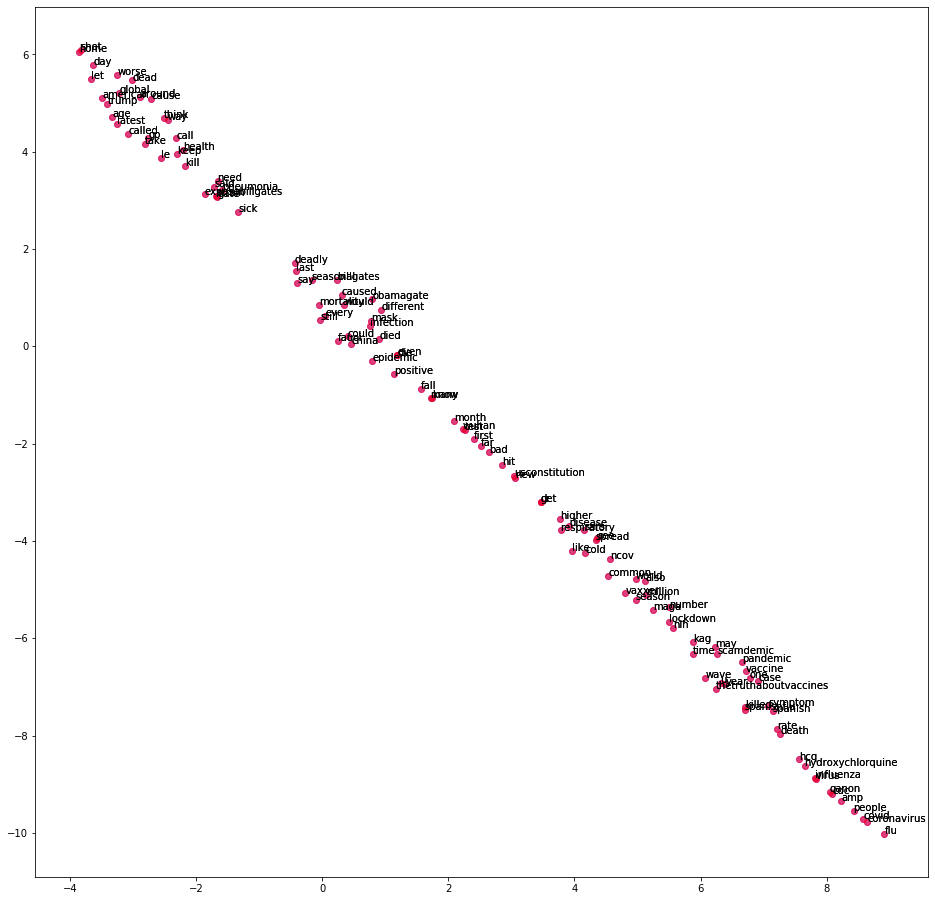

In [28]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(1, 1, 1)
colors = cm.rainbow(np.linspace(0, 1, 2))
for color in colors:
    ax.scatter(df3['x'], df3['y'],c=color,alpha=0.5)
    for word, pos in df3.iterrows():
        ax.annotate(word, pos)

In [ ]:
vocab = list(model.wv.vocab)
X = model[vocab]

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [ ]:
df3 = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

In [ ]:
fig = plt.figure(figsize=(16,16) )
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df3['x'], df3['y'])
for word, pos in df3.iterrows():
    ax.annotate(word, pos)

In [ ]:
df4 = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

In [ ]:
fakes=df.loc[df['label'] == "Fake"]

In [ ]:
fakes

In [ ]:
X=fakes.normalized_tweet.values
model = Word2Vec(X, size=500, window=5, min_count=12, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

In [ ]:
vocab = list(model.wv.vocab)
Xt = model[vocab]

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(Xt)

In [ ]:
df3 = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

In [ ]:
fig = plt.figure(figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df3['x'], df3['y'])
for word, pos in df3.iterrows():
    ax.annotate(word, pos)

In [ ]:
reals=df.loc[df['label'] == "TRUE"]

In [ ]:
X=reals.normalized_tweet.values
model = Word2Vec(X, size=500, window=5, min_count=12, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

In [ ]:
vocab = list(model.wv.vocab)
Xt = model[vocab]

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(Xt)

In [ ]:
df3 = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

In [ ]:
fig = plt.figure(figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df3['x'], df3['y'])
for word, pos in df3.iterrows():
    ax.annotate(word, pos)

In [ ]:
corpus.data

In [29]:
keys=['True','Fake']

In [32]:
X=df2.normalized_tweet.values
y = df2['label'].values
print(X.shape, y.shape)


(417,) (417,)


In [70]:
tf_vector

array([[ 0.30725178,  0.09551901, -0.07842194, ...,  0.03401113,
         0.00910061, -0.05739677],
       [ 0.41617322,  0.11588043, -0.1129678 , ...,  0.06015785,
         0.01052153, -0.08107335],
       [ 0.32362252,  0.09279203, -0.08231982, ...,  0.03880509,
         0.00851664, -0.06254401],
       ...,
       [ 0.37846828,  0.10422931, -0.09963069, ...,  0.05185277,
         0.0142329 , -0.07119855],
       [ 0.40741697,  0.11146869, -0.10398274, ...,  0.05427407,
         0.01505874, -0.06945471],
       [ 0.37017912,  0.10285263, -0.10029713, ...,  0.04513464,
         0.01269081, -0.07612699]])

In [38]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(tf_vector)

In [39]:
df3 = pd.DataFrame(X_tsne, columns=['x', 'y'])

In [40]:
df3['labels'] = y

,x,y,labels
0,-28.317736,7.629925,Fake
1,28.351513,13.320222,Fake
2,-21.077238,1.555582,Fake
3,-14.133156,-3.319730,Fake
4,-16.904192,-5.431395,Fake
...,...,...,...
412,29.954775,14.984796,TRUE
413,30.194902,16.225471,TRUE
414,16.972694,-2.366544,TRUE
415,27.741514,10.872111,TRUE


In [44]:
d = {'Fake': 0, 'TRUE': 1}
colors = [d[x] for x in df3['labels'].values]

In [28]:
colors

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


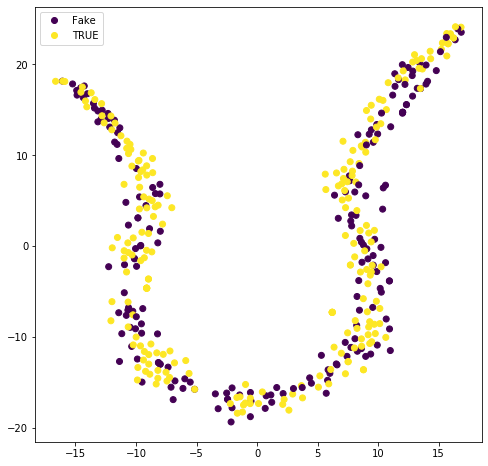

In [42]:
#import matplotlib
lbl=['Fake','TRUE']
fig = plt.figure(figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1)
#cmap = matplotlib.cm.get_cmap('prism')
scatter = ax.scatter(df3['x'], df3['y'],c=colors)
ax.legend(handles=scatter.legend_elements()[0], labels=lbl)

In [103]:
*scatter.legend_elements()

SyntaxError: can't use starred expression here (<ipython-input-103-5ee949c8f954>, line 4)

In [122]:
tf_vector[102]

array([ 0.35531861,  0.0996886 , -0.09142618, -0.12000217,  0.11213312,
        0.0316514 , -0.16979392, -0.11309087,  0.47192341, -0.1333051 ,
        0.06628813, -0.18346027,  0.03207881, -0.00504366, -0.09003332,
       -0.26733676, -0.288735  ,  0.14103857, -0.10307   ,  0.03138654,
       -0.00541786,  0.04042601,  0.09739186, -0.01311762, -0.25776905,
        0.22907586, -0.39723364, -0.19027182, -0.11538792, -0.08266868,
        0.02380039, -0.03812284, -0.00777156,  0.03512335,  0.15689187,
       -0.00223937,  0.12304921,  0.07537371,  0.02561761,  0.33455327,
        0.12015202,  0.38118517, -0.25407609,  0.19108726,  0.1074281 ,
       -0.19334908, -0.03057144, -0.08011551, -0.50234771, -0.07977592,
        0.20356397,  0.67842788, -0.30297223, -0.09687292,  0.06414376,
        0.15827712,  0.09461631,  0.06712663, -0.06178067, -0.14659473,
       -0.0595863 , -0.03023002, -0.17575182,  0.02750557, -0.0062858 ,
        0.09223833, -0.0467323 , -0.26190144, -0.01440515, -0.16

In [142]:
df2.iloc[250]

screen_name         NotSoProudYank                                                                                                                                                                                                                                                  
tweet               I was reading more about the 1918 Spanish Flu Pandemic and saw that it reappeared twice after the first wave, not just once. \n\nExperts have said #coronavirus, #COVID19 will most likely reappear again and I'm wondering if there could also be a third time.
label               TRUE                                                                                                                                                                                                                                                            
normalized_tweet    [reading, spanish, flu, pandemic, saw, reappeared, twice, first, wave, expert, said, coronavirus, covid, likely, reappear, wondering, could, also, th

In [140]:
d = {'Fake': 0, 'TRUE': 1}
colors = [d[x] for x in lb]

ValueError: 'c' argument has 417 elements, which is not acceptable for use with 'x' with size 3, 'y' with size 3.

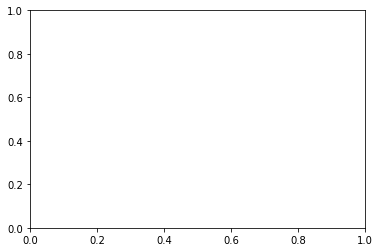

In [45]:
y = [-28.3177, -21.0772, -26.0835]
z = [7.62992, 1.55558, 7.90825]
lb=['Fake','Fake','TRUE']
n = ['0.01% death rate, lower than the seasonal flu! #CoronaVirusHOAX #OPENAMERICANOW', 'It’s all a Hoax and a farce. Not any worse than the seasonal flu. All the hype is politically motivated.\n Almost all of Flu cases have been claimed as Covid19. All China based Virus is a Coronavirus.\n Covid19 is a different strain of the Seasonal Flu.', 'Can the flu vaccination stop Covid-19?\n\nNo, the flu vaccine will not stop #Coronavirus.. ']
lbl=['Fake','TRUE']
fig, ax = plt.subplots()
ax.scatter(y, z,c=colors)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))